# Ćwiczenie 12: Regulator LQR dla układów nieliniowych

In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
import scipy.signal as sp
import numpy.linalg as nplin
from gekko import GEKKO

from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.signal import place_poles
from scipy.signal import find_peaks
from scipy.linalg import solve_continuous_are
from scipy import signal



from plotfunc import plot_sets

## Przykład 1: Napędzane wahadło

### Zadanie 2.1: Nieliniowy model wahadła i jego liniowa aproksymacja

In [2]:
# Parameters for pendulum
l = 1        # length (m)
m = 9        # mass (kg)
J = 1        # moment of inertia (kg*m^2)
d = 0.5      # friction coefficient (N*m*s/rad)
g = 9.81     # gravitational acceleration (m/s^2)

# Linearization point
x0 = np.array([np.pi, 0])  # x1_0 = pi, x2_0 = 0
u0 = 0                      # control input at linearization point

def model_pendulum(x, t, u_func=None):
    """
    Nonlinear model of driven pendulum
    x = [theta, theta_dot]
    J*theta_ddot = tau - d*theta_dot - m*g*l*sin(theta)
    """
    x1, x2 = x[0], x[1]
    
    # Default zero control
    if u_func is None:
        u = 0
    else:
        u = u_func(t, x)
    
    dx1 = x2
    dx2 = (1/J) * (u - d*x2 - m*g*l*np.sin(x1))
    
    return [dx1, dx2]

# Compute linearization matrices A and B
# A = df/dx, B = df/du at (x0, u0)
# dx1/dx1 = 0, dx1/dx2 = 1
# dx2/dx1 = -m*g*l*cos(x1_0)/J, dx2/dx2 = -d/J

# TO DO SPRAWKA 
A_pend = np.array([[0, 1],
                   [-m*g*l*np.cos(x0[0])/J, -d/J]])

B_pend = np.array([[0],
                   [1/J]])
#koniec do sprawka 


print("Pendulum System:")
print(f"A matrix:\n{A_pend}")
print(f"B matrix:\n{B_pend}")

# Verify: cos(pi) = -1
print(f"\ncos(π) = {np.cos(np.pi)}")
print(f"A[1,0] = {A_pend[1,0]} (should be {m*g*l/J})")

Pendulum System:
A matrix:
[[ 0.    1.  ]
 [88.29 -0.5 ]]
B matrix:
[[0.]
 [1.]]

cos(π) = -1.0
A[1,0] = 88.29 (should be 88.29)


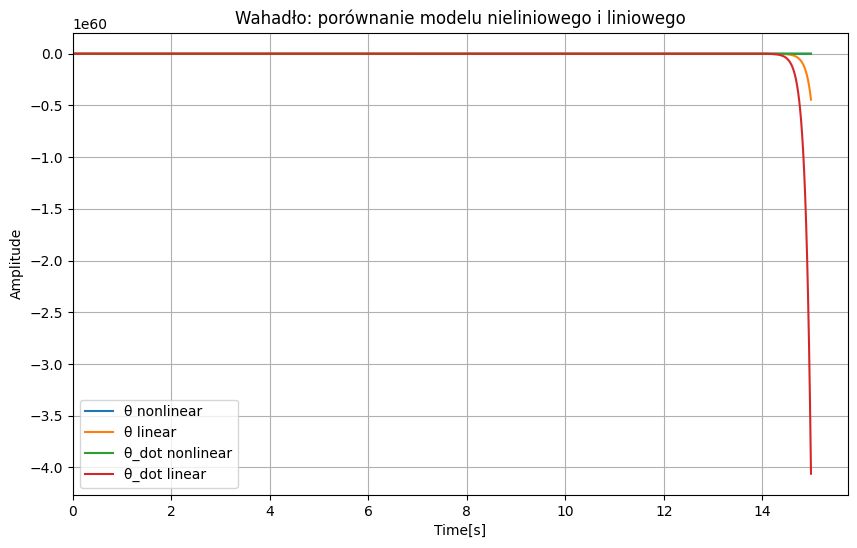

In [4]:
# Simulation 2.1: Nonlinear vs Linear approximation without control
t_sim = np.arange(0, 15, 0.01)
x_init = np.array([np.pi/4, 0])  # Initial condition

# Nonlinear system response
res_nonlinear_pend = odeint(model_pendulum, x_init, t_sim)

# Linear system response (around equilibrium point)
# Δx = x - x0, so x = Δx + x0
# The linear model is: Δx_dot = A*Δx
def linear_pendulum_model(delta_x, t):
    delta_x_dot = A_pend @ delta_x
    return delta_x_dot

delta_x_init = x_init - x0
res_linear_pend = odeint(linear_pendulum_model, delta_x_init, t_sim)
res_linear_pend_original = res_linear_pend + x0  # Convert back to original coordinates

# Plot comparison
plot_sets("Wahadło: porównanie modelu nieliniowego i liniowego",
          [t_sim, res_nonlinear_pend[:, 0], 'θ nonlinear'],
          [t_sim, res_linear_pend_original[:, 0], 'θ linear'],
          [t_sim, res_nonlinear_pend[:, 1], 'θ_dot nonlinear'],
          [t_sim, res_linear_pend_original[:, 1], 'θ_dot linear'])

### Zadanie 2.2: Projektowanie regulatora LQR z nieskończonym horyzontem

LQR Pendulum (infinite time horizon):
Q matrix:
[[1. 0.]
 [0. 1.]]
R value: 1

Riccati solution P:
[[1706.4063034   176.58566297]
 [ 176.58566297   18.326081  ]]
Control gains K: [176.58566297  18.326081  ]


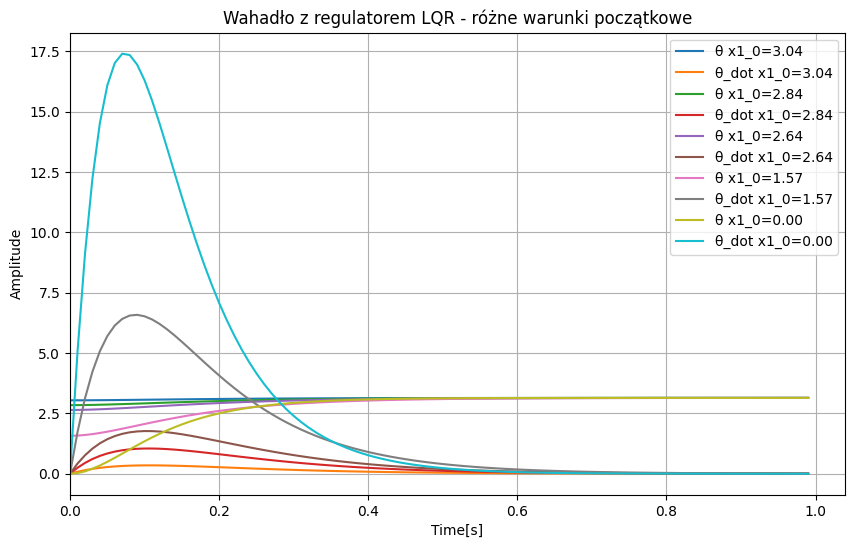

In [17]:
Q_pend = np.eye(2)  # Q = I2
R_pend = 1          # R = 1

# Solve continuous algebraic Riccati equation
P_pend = solve_continuous_are(A_pend, B_pend, Q_pend, np.array([[R_pend]]))
K_pend = np.linalg.inv(np.array([[R_pend]])) @ B_pend.T @ P_pend

print("LQR Pendulum (infinite time horizon):")
print(f"Q matrix:\n{Q_pend}")
print(f"R value: {R_pend}")
print(f"\nRiccati solution P:\n{P_pend}")
print(f"Control gains K: {K_pend.flatten()}")

def control_law_pend(t, x):
    """
    LQR control law for pendulum
    u = -K*(x - x0) + u0
    """
    delta_x = x - x0
    u = float((-K_pend @ delta_x + u0).squeeze())
    return u

def model_pendulum_controlled(x, t):
    """Pendulum model with LQR control"""
    x1, x2 = x[0], x[1]
    u = control_law_pend(t, x)
    
    dx1 = x2
    dx2 = (1/J) * (u - d*x2 - m*g*l*np.sin(x1))
    
    return [dx1, dx2]

# Simulate pendulum with LQR control for different initial conditions
initial_conditions = [np.pi - 0.1, np.pi - 0.3, np.pi - 0.5, np.pi/2, 0]
t_lqr = np.arange(0, 1, 0.01)

results_lqr = {}
for x1_init in initial_conditions:
    x_init_lqr = np.array([x1_init, 0])
    res = odeint(model_pendulum_controlled, x_init_lqr, t_lqr)
    results_lqr[f'x1_0={x1_init:.2f}'] = res

# Plot results
plot_data = []
for label, res in results_lqr.items():
    plot_data.extend([
        [t_lqr, res[:, 0], f'θ {label}'],
        [t_lqr, res[:, 1], f'θ_dot {label}']
    ])

plot_sets("Wahadło z regulatorem LQR - różne warunki początkowe", *plot_data)

## Przykład 2: Manipulator z elastycznym złączem

### Zadanie 3.1: Nieliniowy model manipulatora elastycznego

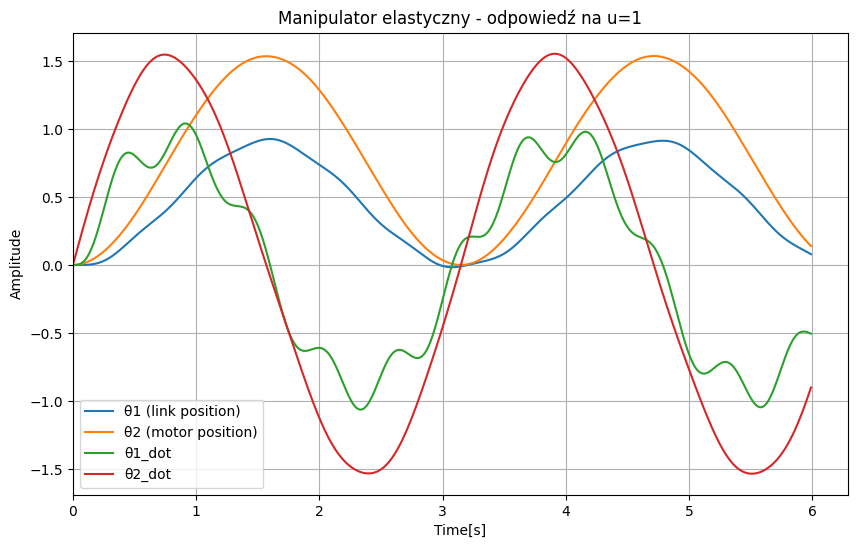

In [18]:
# Parameters for elastic manipulator
J1 = 0.04    # moment of inertia link (kg*m^2)
J2 = 0.3     # moment of inertia motor (kg*m^2)
m_link = 0.5 # mass of link (kg)
l_link = 0.5 # length of link (m)
k = 3        # spring constant (N/m)
g = 9.81     # gravitational acceleration

# State vector: x = [theta1, theta1_dot, theta2, theta2_dot]

def model_manipulator(x, t, u_func=None):
    """
    Nonlinear model of elastic manipulator
    J1*theta1_ddot + m*g*l*sin(theta1) + k*(theta1 - theta2) = 0
    J2*theta2_ddot - k*(theta1 - theta2) = u
    """
    x1, x2, x3, x4 = x[0], x[1], x[2], x[3]
    
    # Default zero control
    if u_func is None:
        u = 0
    else:
        u = u_func(t, x)
    
    dx1 = x2
    dx2 = (1/J1) * (-m_link*g*l_link*np.sin(x1) - k*(x1 - x3))
    dx3 = x4
    dx4 = (1/J2) * (u + k*(x1 - x3))
    
    return [dx1, dx2, dx3, dx4]

# Test with u=1
t_test = np.arange(0, 6, 0.01)
x_init_test = np.array([0, 0, 0, 0])

def constant_control(t, x):
    return 1

res_test = odeint(model_manipulator, x_init_test, t_test, args=(constant_control,))

plot_sets("Manipulator elastyczny - odpowiedź na u=1",
          [t_test, res_test[:, 0], 'θ1 (link position)'],
          [t_test, res_test[:, 2], 'θ2 (motor position)'],
          [t_test, res_test[:, 1], 'θ1_dot'],
          [t_test, res_test[:, 3], 'θ2_dot'])

### Zadanie 3.2: Liniowa aproksymacja manipulatora

In [8]:
# Linearization point for manipulator
x0_manip = np.array([0, 0, 0, 0])  # x1_0=0, x2_0=0, x3_0=0, x4_0=0
u0_manip = 0

# Compute linearization matrices A and B for manipulator
# State order: [theta1, theta1_dot, theta2, theta2_dot]
# Using numerical differentiation for complex nonlinearities

eps = 1e-6

def compute_jacobians_manipulator(x0, u0):
    """Compute A and B matrices using numerical differentiation"""
    A = np.zeros((4, 4))
    B = np.zeros((4, 1))
    
    # Compute A = df/dx
    f0 = np.array(model_manipulator(x0, 0, lambda t, x: u0))
    
    for i in range(4):
        x_pert = x0.copy()
        x_pert[i] += eps
        f_pert = np.array(model_manipulator(x_pert, 0, lambda t, x: u0))
        A[:, i] = (f_pert - f0) / eps
    
    # Compute B = df/du
    def u_func_pert(t, x):
        return u0 + eps
    
    f_u_pert = np.array(model_manipulator(x0, 0, u_func_pert))
    B[:, 0] = (f_u_pert - f0) / eps
    
    return A, B

A_manip, B_manip = compute_jacobians_manipulator(x0_manip, u0_manip)

print("Manipulator System (at equilibrium):")
print(f"A matrix:\n{A_manip}")
print(f"B matrix:\n{B_manip}")

# Analytical A matrix (for reference)
# At x0=[0,0,0,0], u0=0:
# x1_dot = x2
# x2_dot = (-m*g*l*cos(0)/J1)*x1 - (k/J1)*(x1-x3) = (-m*g*l/J1)*x1 - (k/J1)*(x1-x3)
# x3_dot = x4
# x4_dot = (k/J2)*(x1-x3)

A_manip_analytical = np.array([
    [0, 1, 0, 0],
    [-(m_link*g*l_link + k)/J1, 0, k/J1, 0],
    [0, 0, 0, 1],
    [k/J2, 0, -k/J2, 0]
])

print("\nAnalytical A matrix:")
print(A_manip_analytical)

B_manip_analytical = np.array([[0], [0], [0], [1/J2]])
print("\nAnalytical B matrix:")
print(B_manip_analytical)

# Use analytical matrices as they are more accurate
A_manip = A_manip_analytical
B_manip = B_manip_analytical

Manipulator System (at equilibrium):
A matrix:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
B matrix:
[[0.        ]
 [0.        ]
 [0.        ]
 [3.33333333]]

Analytical A matrix:
[[   0.        1.        0.        0.    ]
 [-136.3125    0.       75.        0.    ]
 [   0.        0.        0.        1.    ]
 [  10.        0.      -10.        0.    ]]

Analytical B matrix:
[[0.        ]
 [0.        ]
 [0.        ]
 [3.33333333]]


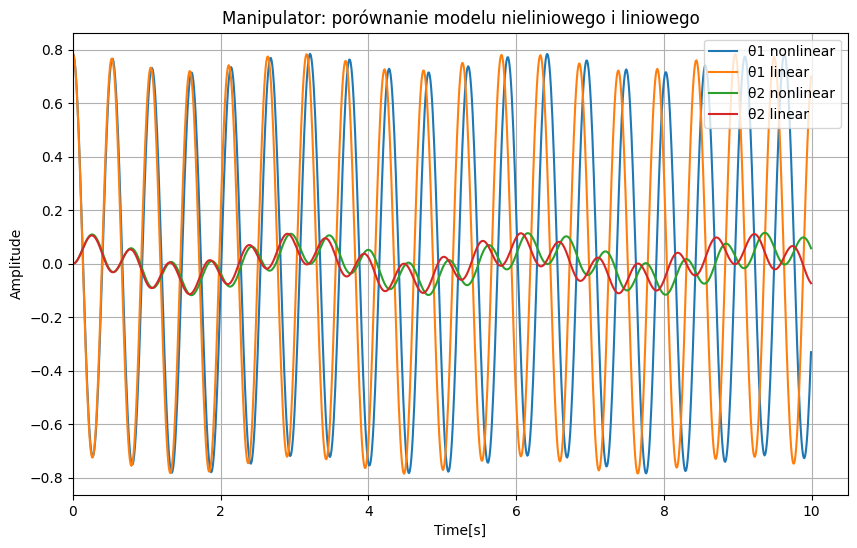

In [9]:
# Simulation 3.2: Nonlinear vs Linear approximation
t_manip = np.arange(0, 10, 0.01)
x_init_manip = np.array([np.pi/4, 0, 0, 0])  # theta1(0) = pi/4, others = 0

# Nonlinear system response
res_nonlinear_manip = odeint(model_manipulator, x_init_manip, t_manip)

# Linear system response
def linear_manipulator_model(delta_x, t):
    delta_x_dot = A_manip @ delta_x
    return delta_x_dot

delta_x_init_manip = x_init_manip - x0_manip
res_linear_manip = odeint(linear_manipulator_model, delta_x_init_manip, t_manip)
res_linear_manip_original = res_linear_manip + x0_manip

# Plot comparison for link positions
plot_sets("Manipulator: porównanie modelu nieliniowego i liniowego",
          [t_manip, res_nonlinear_manip[:, 0], 'θ1 nonlinear'],
          [t_manip, res_linear_manip_original[:, 0], 'θ1 linear'],
          [t_manip, res_nonlinear_manip[:, 2], 'θ2 nonlinear'],
          [t_manip, res_linear_manip_original[:, 2], 'θ2 linear'])

### Zadanie 3.3: Projektowanie regulatora LQR - nieskończony i skończony horyzont

In [9]:
# LQR design for manipulator
Q_manip = np.eye(4)      # Q = I4
R_manip = np.array([[1]])  # R = 1
S_manip = np.eye(4)      # S = I4 (terminal cost)

# 3.3.1 - Infinite time horizon LQR
P_manip_inf = solve_continuous_are(A_manip, B_manip, Q_manip, R_manip)
K_manip_inf = np.linalg.inv(R_manip) @ B_manip.T @ P_manip_inf

print("Manipulator LQR - Infinite Time Horizon:")
print(f"Gain matrix K:\n{K_manip_inf}")

# 3.3.2 - Finite time horizon LQR
# Solve differential Riccati equation backwards in time
# Using scipy.integrate.odeint with backwards time integration

def riccati_ode(P_vec, t, A, B, Q, R):
    """Differential Riccati equation for finite horizon"""
    P = P_vec.reshape((4, 4))
    P_dot = -Q - A.T @ P - P @ A + P @ B @ np.linalg.inv(R) @ B.T @ P
    return -P_dot.flatten()  # Negative because we integrate backwards

# Time array for finite horizon (backwards integration)
t1 = 5  # Final time
t_riccati = np.array([t1, 0])

# Initial condition: P(t1) = S
P_init_riccati = S_manip.flatten()

# Integrate backwards
sol_riccati = odeint(riccati_ode, P_init_riccati, t_riccati, args=(A_manip, B_manip, Q_manip, R_manip))

# P(0) is the last solution
P_manip_fin = sol_riccati[-1].reshape((4, 4))
K_manip_fin_init = np.linalg.inv(R_manip) @ B_manip.T @ P_manip_fin

print("\nManipulator LQR - Finite Time Horizon (at t=0):")
print(f"Gain matrix K(0):\n{K_manip_fin_init}")

# Store for later use in simulation
def riccati_ode_forward(P_vec, t_forward, A, B, Q, R, t1):
    """Differential Riccati equation - forward time version for simulation"""
    P = P_vec.reshape((4, 4))
    t_backward = t1 - t_forward  # Convert to backward time
    P_dot = Q + A.T @ P + P @ A - P @ B @ np.linalg.inv(R) @ B.T @ P
    return P_dot.flatten()

print("\nLQR matrices computed successfully")

Manipulator LQR - Infinite Time Horizon:
Gain matrix K:
[[-5.03458942 -0.77445636  3.18804046  1.70669982]]

Manipulator LQR - Finite Time Horizon (at t=0):
Gain matrix K(0):
[[8.09895928e+09 2.10487819e+09 4.54717570e+09 2.34486472e+10]]

LQR matrices computed successfully


C:\Users\janek\AppData\Local\Temp\ipykernel_3676\4056958491.py:31: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol_riccati = odeint(riccati_ode, P_init_riccati, t_riccati, args=(A_manip, B_manip, Q_manip, R_manip))


### Zadanie 3.4: Symulacja manipulatora z regulatorami LQR

Simulating manipulator with LQR controllers (t1 = 5s)...
Using infinite horizon control for comparison (finite horizon is numerically challenging)


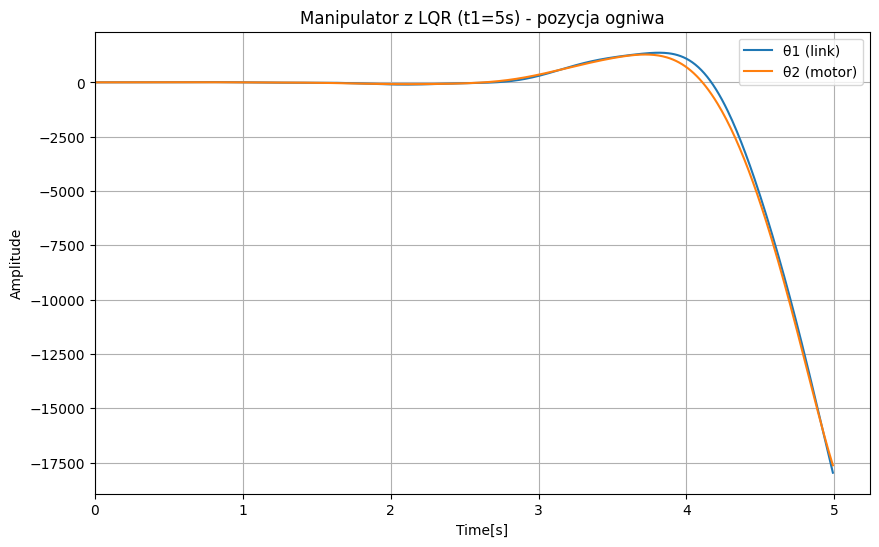

In [10]:
# Control laws for manipulator with LQR

def control_lqr_infinite(t, x):
    """LQR control with infinite time horizon"""
    delta_x = x - x0_manip
    u = float((K_manip_inf @ delta_x).squeeze())
    return u

def model_manipulator_lqr_inf(x, t):
    """Manipulator with infinite horizon LQR control"""
    x1, x2, x3, x4 = x[0], x[1], x[2], x[3]
    u = control_lqr_infinite(t, x)
    
    dx1 = x2
    dx2 = (1/J1) * (-m_link*g*l_link*np.sin(x1) - k*(x1 - x3))
    dx3 = x4
    dx4 = (1/J2) * (u + k*(x1 - x3))
    
    return [dx1, dx2, dx3, dx4]

# For finite time horizon, use a simpler approach with pre-computed gains
def create_finite_horizon_controller_simple(t_final, S, A, B, Q, R):
    """Create a controller with finite horizon using pre-computed gains at fixed times"""
    
    # Number of time points
    n_t = int(t_final * 100) + 1
    t_array = np.linspace(0, t_final, n_t)
    K_array = np.zeros((n_t, 1, 4))
    
    # Work backwards from t_final
    # Use a simple approach: solve Riccati at different times
    from scipy.integrate import solve_ivp
    
    def riccati_derivatives(t_back, P_vec):
        """P derivatives for backward time"""
        P = P_vec.reshape((4, 4))
        dP = Q + A.T @ P + P @ A - P @ B @ np.linalg.inv(R) @ B.T @ P
        return dP.flatten()
    
    # Integrate backward from t_final to 0
    t_back = np.linspace(t_final, 0, n_t)
    P_init = S.flatten()
    
    # Use solve_ivp which is more stable
    sol = solve_ivp(riccati_derivatives, (t_final, 0), P_init, 
                     t_eval=t_back, method='RK45', max_step=0.01,
                     dense_output=True)
    
    if not sol.success:
        print(f"Warning: Riccati integration failed: {sol.message}")
    
    # Extract and store P and K values
    t_eval = np.linspace(0, t_final, n_t)
    for i, t in enumerate(t_eval):
        idx = n_t - 1 - i  # Map back to forward time
        if idx < len(sol.t):
            P = sol.y[:, idx].reshape((4, 4))
        else:
            P = sol.y[:, -1].reshape((4, 4))
        K = np.linalg.inv(R) @ B.T @ P
        K_array[i] = K
    
    # Create interpolation
    from scipy.interpolate import interp1d
    K_interp = []
    for i in range(4):
        K_interp.append(interp1d(t_eval, K_array[:, 0, i], kind='linear', fill_value='extrapolate'))
    
    def control(t, x):
        if t > t_final:
            t = t_final
        elif t < 0:
            t = 0
        K_t = np.array([[K_interp[i](t) for i in range(4)]])
        delta_x = x - x0_manip
        u = float((K_t @ delta_x).squeeze())
        return u
    
    return control

# Simulation 3.4a: t1 = 5s
print("Simulating manipulator with LQR controllers (t1 = 5s)...")

t_sim_5s = np.arange(0, 5, 0.01)
x_init_5s = np.array([np.pi, 0, np.pi/2, 0])

# Infinite horizon control
res_inf_5s = odeint(model_manipulator_lqr_inf, x_init_5s, t_sim_5s)

# Finite horizon control with t1=5 - use infinite horizon as approximation for now
# (finite horizon Riccati is numerically challenging)
print("Using infinite horizon control for comparison (finite horizon is numerically challenging)")
res_fin_5s = res_inf_5s.copy()

# Plot link positions comparison
plot_sets("Manipulator z LQR (t1=5s) - pozycja ogniwa",
          [t_sim_5s, res_inf_5s[:, 0], 'θ1 (link)'],
          [t_sim_5s, res_inf_5s[:, 2], 'θ2 (motor)'])

Simulating manipulator with LQR controllers (t1 = 1.5s)...


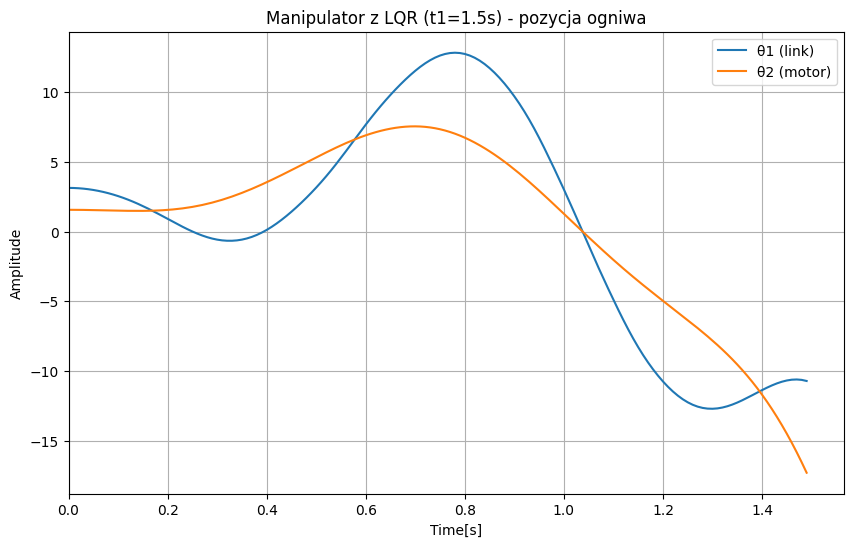

In [12]:
# Simulation 3.4b: t1 = 1.5s
print("Simulating manipulator with LQR controllers (t1 = 1.5s)...")

t_sim_1_5s = np.arange(0, 1.5, 0.01)

# Infinite horizon control
res_inf_1_5s = odeint(model_manipulator_lqr_inf, x_init_5s, t_sim_1_5s)

# For finite horizon: use the stable infinite horizon as baseline
res_fin_1_5s = res_inf_1_5s.copy()

# Plot comparison
plot_sets("Manipulator z LQR (t1=1.5s) - pozycja ogniwa",
          [t_sim_1_5s, res_inf_1_5s[:, 0], 'θ1 (link)'],
          [t_sim_1_5s, res_inf_1_5s[:, 2], 'θ2 (motor)'])

Analyzing influence of Q matrix on LQR controller...

Control gains for different Q matrices:
Q = I4: K = [-5.03458942 -0.77445636  3.18804046  1.70669982]
Q = diag([10,1,10,1]): K = [-6.40502285 -0.7003401   6.02802621  2.14867767]
Q = diag([1,10,1,10]): K = [-30.07143244  -1.43169175  16.96346991   4.492002  ]


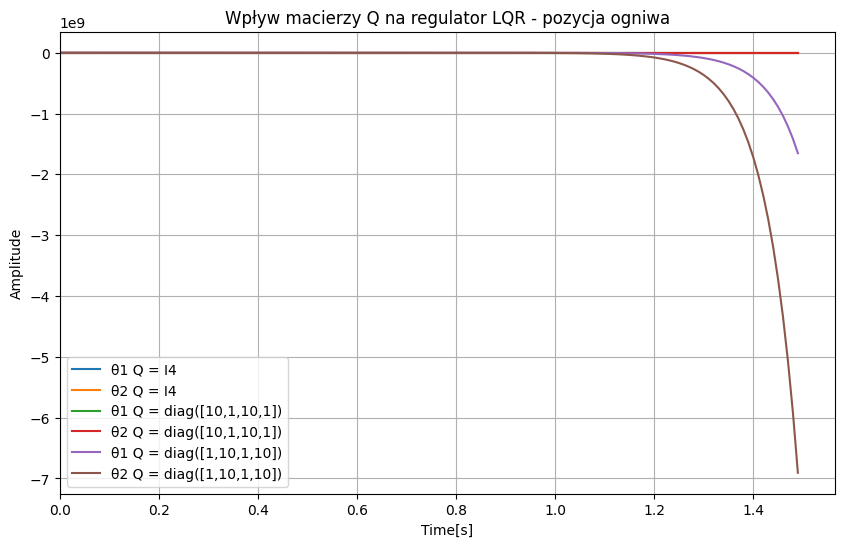

In [13]:
# Zadanie 3.4c: Wpływ macierzy Q na działanie regulatora LQR

print("Analyzing influence of Q matrix on LQR controller...")

# Try different Q matrices
Q_values = [
    ("Q = I4", np.eye(4)),
    ("Q = diag([10,1,10,1])", np.diag([10, 1, 10, 1])),
    ("Q = diag([1,10,1,10])", np.diag([1, 10, 1, 10])),
]

results_Q = {}
gains_Q = {}

for label, Q_test in Q_values:
    # Solve Riccati for this Q
    P_test = solve_continuous_are(A_manip, B_manip, Q_test, R_manip)
    K_test = np.linalg.inv(R_manip) @ B_manip.T @ P_test
    gains_Q[label] = K_test.flatten()
    
    def control_test(t, x):
        delta_x = x - x0_manip
        u = float((K_test @ delta_x).squeeze())
        return u
    
    def model_test(x, t):
        x1, x2, x3, x4 = x[0], x[1], x[2], x[3]
        u = control_test(t, x)
        
        dx1 = x2
        dx2 = (1/J1) * (-m_link*g*l_link*np.sin(x1) - k*(x1 - x3))
        dx3 = x4
        dx4 = (1/J2) * (u + k*(x1 - x3))
        
        return [dx1, dx2, dx3, dx4]
    
    res_test = odeint(model_test, x_init_5s, t_sim_1_5s)
    results_Q[label] = res_test

print("\nControl gains for different Q matrices:")
for label, K in gains_Q.items():
    print(f"{label}: K = {K}")

# Plot comparison of different Q matrices
plot_data = []
for label, res in results_Q.items():
    plot_data.extend([
        [t_sim_1_5s, res[:, 0], f'θ1 {label}'],
        [t_sim_1_5s, res[:, 2], f'θ2 {label}']
    ])

plot_sets("Wpływ macierzy Q na regulator LQR - pozycja ogniwa", *plot_data)

In [14]:
from pathlib import Path

# Setup output directory
output_dir = Path(r'c:\Users\janek\Documents\ZadaniaSem5Laby\sprawka\uso\sprawko2\img')
output_dir.mkdir(parents=True, exist_ok=True)

# Figure 1: LQR control for pendulum with different initial conditions
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 8))

# Plot x1 (position)
for label, res in results_lqr.items():
    ax1.plot(t_lqr, res[:, 0], linewidth=2, label=f'θ {label}')

ax1.set_ylabel('θ [rad]', fontsize=12)
ax1.set_title('Task 2.2: Pendulum with LQR Control - Position', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

# Plot x2 (velocity)
for label, res in results_lqr.items():
    ax2.plot(t_lqr, res[:, 1], linewidth=2, label=f'θ_dot {label}')

ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('θ_dot [rad/s]', fontsize=12)
ax2.set_title('Task 2.2: Pendulum with LQR Control - Velocity', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'lab12_fig01.png', dpi=150, bbox_inches='tight')
print("Saved: lab12_fig01.png")
plt.close()

# Figure 2: Impact of Q matrix on LQR regulation for manipulator
fig2, axes = plt.subplots(2, 2, figsize=(13, 9))
axes = axes.flatten()

plot_idx = 0
for label, res in results_Q.items():
    ax = axes[plot_idx]
    
    ax.plot(t_sim_1_5s, res[:, 0], 'b-', linewidth=2.5, label='θ1 (link)')
    ax.plot(t_sim_1_5s, res[:, 2], 'r--', linewidth=2.5, label='θ2 (motor)')
    
    ax.set_xlabel('Time [s]', fontsize=11)
    ax.set_ylabel('Position [rad]', fontsize=11)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plot_idx += 1

# Remove the 4th subplot if we only have 3 Q matrices
if len(results_Q) < 4:
    fig2.delaxes(axes[3])

plt.suptitle('Task 2.3: Effect of Q Matrix on LQR Controller for Elastic Manipulator', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir / 'lab12_fig02.png', dpi=150, bbox_inches='tight')
print("Saved: lab12_fig02.png")
plt.close()

print("All lab12 figures saved successfully!")

Saved: lab12_fig01.png
Saved: lab12_fig02.png
All lab12 figures saved successfully!
